<a href="https://colab.research.google.com/github/jm0nt1/sinusoidal_autoencoder/blob/main/autoencoder_senoidales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoder Lineal
Esto es una prueba del uso de un autoencoder para señales que son combinaciones lineales de 3 senoidales de frecuencia fija.\
\
Dado
$$
\mathbf{t} = \left\{ t_i \right\}_{i=0}^{N-1}
$$
\
donde $t_i $ son $ N=1000 $ valores igualmente espaciados en el intervalo $\left[0, 1 - \frac{1}{N}\right].$

Luego,
$$
\mathbf{x} = a.cos(2\pi \mathbf{t}) + b.cos(4\pi \mathbf{t}) + c.cos(6\pi \mathbf{t})
$$
donde $a,b,c \in \left [ 0, 1 \right ] $ son generados aleatoriamente.


#Objetivos
La idea es visualizar: \
- Reconstrucción de las señales.
- Valores de los parámetros del espacio latente.
- Matriz del encoder y decoder.

#Código

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from scipy.io import loadmat
import random
import os
import numpy as np
import matplotlib.pyplot as plt

Generamos una clase heredada de Dataset para cargar nuestras señales.

In [ ]:
def senoidal_function_generate(N, device):
    t = torch.linspace(0, 1 - 1/N, N)

    a = random.uniform(-0.5,0.5)  # Amplitud aleatoria para la primera componente
    b = random.uniform(-0.5,0.5)  # Amplitud aleatoria para la segunda componente
    c = random.uniform(-0.5,0.5)  # Amplitud aleatoria para la tercera componente

    # Generar la señal senoidal combinada
    x = a * torch.cos(2 * torch.pi * t) + b * torch.cos(4 * torch.pi * t) + c * torch.cos(6 * torch.pi * t)

    x = x.to(device)
    x = x.to(torch.float32)

    return [a,b,c], x

class CosenoDataset(Dataset):
    def __init__(self,device):
        n_samples = 100000
        N = 1000
        data = torch.zeros(n_samples, N)

        for i in range(n_samples):
          _, data[i, :] = senoidal_function_generate(N,device)

        self.x = data.to(device)

        # Guardo la cantidad de samples para mostrarlos en len
        self.n_samples = self.x.shape[0]

    def __getitem__(self, index):
        return self.x[index]

    def __len__(self):
        return self.n_samples


Creamos la clase del autoencoder con su correspondiente arquitectura. \
La idea es que pueda codificar los coeficientes a,b y c de las distintas señales, por lo que el espacio latente será de dimensión $[1,3]$\
Las señales senoidales estarán codificadas en la matriz del encoder, de dimensión $[3,1000]$

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        # Creo el Encoder
        self.encoder = nn.Sequential(
            nn.Linear(1000,3),
        )
        # Creo el Decoder
        self.decoder = nn.Sequential(
            nn.Linear(3,1000),
        )

    def forward(self,x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

Cargo el Dataset

In [ ]:
# Parámetros de entrenamiento
BS = 1024
LR = 1e-03
WD = 1e-05
EPOCHS = 40

#
if torch.cuda.is_available()==True:
  device="cuda:0"
  print(f"Device: {device}")
else:
  device ="cpu"
  print(f"Device: {device}")

# Cargar los datos
my_dataset = CosenoDataset(device)
data_loader = DataLoader(
    dataset=my_dataset,
    batch_size=BS,
    shuffle=True)

Device: cpu


Visualizamos algunas señales

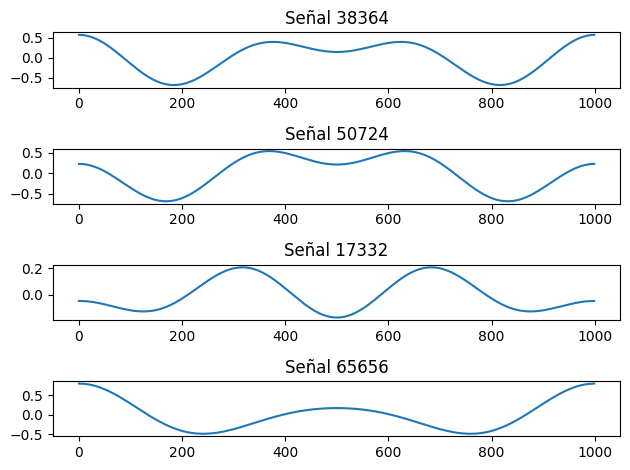

In [ ]:
# selecciono 4 muestras aleatorias
random_idx = random.sample(range(len(my_dataset)),4)
fig,axs = plt.subplots(4,1)
for i in range(4):
    axs[i].plot(my_dataset[random_idx[i]])
    axs[i].set_title(f"Señal {random_idx[i]}")
fig.tight_layout()
plt.show()

Entrenamiento

In [ ]:
# Inicializo el modelo, la función de costo (Loss) y el optimizador
model = Autoencoder().to(device)

criterion = nn.MSELoss() #error cuadrático medio
optimizer = torch.optim.Adam( #optimización del gradiente
    model.parameters(),
    lr=LR)

# Bucle de Entrenamiento
total_step = len(data_loader)
model.train()

# para graficar loss vs epoch
losslist = list()
running_loss = 0.0

for epoch in range(EPOCHS):
    for i, x in enumerate(data_loader):
        # cambio el tipo de dato para que sea compatible con el dtype del modelo (float32 by default)
        x = x.to(torch.float32)

        optimizer.zero_grad()
        x_estimate = model(x)
        loss = criterion(x_estimate,x)
        loss.backward()
        optimizer.step()

        running_loss+=loss.item()

        if (i+1) % total_step == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, EPOCHS, i+1, total_step, running_loss/(i+1)))

    losslist.append(running_loss/len(data_loader))
    running_loss = 0.0


Epoch [1/40], Step [98/98], Loss: 0.2081
Epoch [2/40], Step [98/98], Loss: 0.1520
Epoch [3/40], Step [98/98], Loss: 0.1047
Epoch [4/40], Step [98/98], Loss: 0.0718
Epoch [5/40], Step [98/98], Loss: 0.0443
Epoch [6/40], Step [98/98], Loss: 0.0248
Epoch [7/40], Step [98/98], Loss: 0.0134
Epoch [8/40], Step [98/98], Loss: 0.0072
Epoch [9/40], Step [98/98], Loss: 0.0038
Epoch [10/40], Step [98/98], Loss: 0.0019
Epoch [11/40], Step [98/98], Loss: 0.0009
Epoch [12/40], Step [98/98], Loss: 0.0004
Epoch [13/40], Step [98/98], Loss: 0.0002
Epoch [14/40], Step [98/98], Loss: 0.0001
Epoch [15/40], Step [98/98], Loss: 0.0000
Epoch [16/40], Step [98/98], Loss: 0.0000
Epoch [17/40], Step [98/98], Loss: 0.0000
Epoch [18/40], Step [98/98], Loss: 0.0000
Epoch [19/40], Step [98/98], Loss: 0.0000
Epoch [20/40], Step [98/98], Loss: 0.0000
Epoch [21/40], Step [98/98], Loss: 0.0000
Epoch [22/40], Step [98/98], Loss: 0.0000
Epoch [23/40], Step [98/98], Loss: 0.0000
Epoch [24/40], Step [98/98], Loss: 0.0000
E

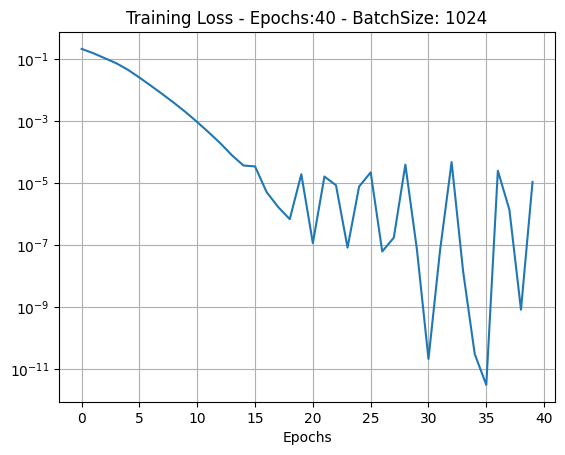

In [ ]:
# Grafico el error
fig,ax = plt.subplots()
ax.semilogy(range(len(losslist)),losslist)
ax.set_xlabel("Epochs")
ax.set_title(f"Training Loss - Epochs:{EPOCHS} - BatchSize: {BS}")
ax.grid()
plt.show()

Visualizamos unos ejemplos de reconstrucción, generando una nueva señal

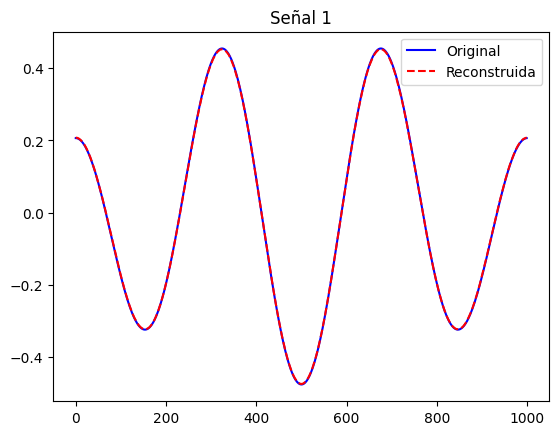

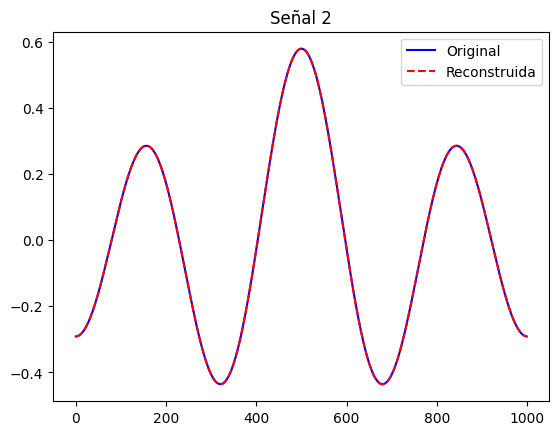

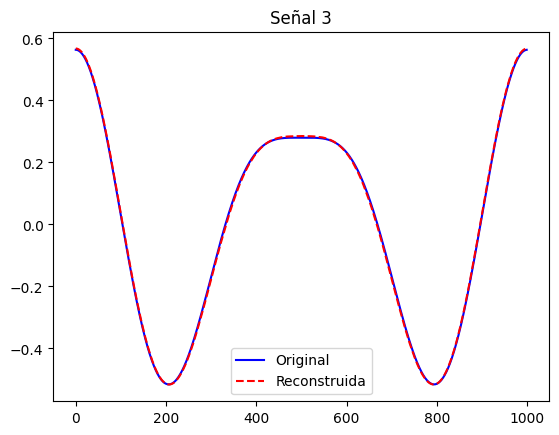

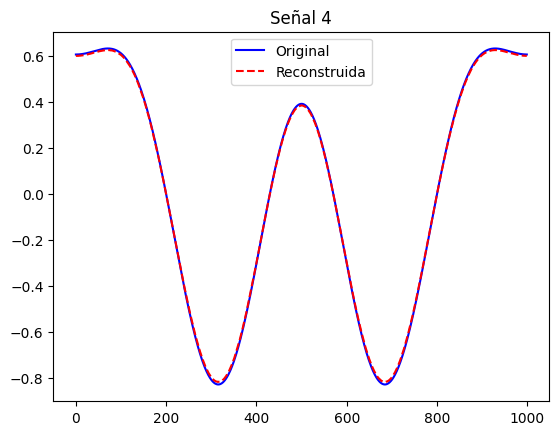

In [ ]:
N=1000
amplitudes = []
ejemplos = []
recons = []

for i in range(4):
  amp,ej = senoidal_function_generate(N,device)
  amplitudes.append(amp)
  ejemplos.append(ej)

  model.eval()
  with torch.no_grad():
      re = model(ejemplos[i].unsqueeze(0))
      recons.append(re.squeeze())

  #visualizamos la original y la reconstruida
  fig, ax=plt.subplots()
  ax.plot(ejemplos[i].cpu().detach().numpy(),"-b",label="Original")
  ax.plot(recons[i].cpu().detach().numpy(),"--r",label="Reconstruida")
  ax.set_title(f"Señal {i+1}")

  ax.legend()
  #fig.tight_layout()
  fig.show()


Visualizar matriz de encoder

In [ ]:
param_modelo = [*model.parameters()]
print(param_modelo[0].shape)

torch.Size([3, 1000])


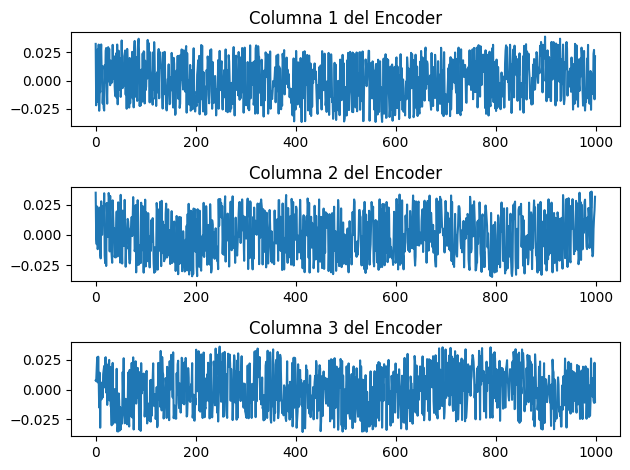

In [ ]:
p = param_modelo[0].shape[0]
fig, axs = plt.subplots(p,1)
for i in range(p):
  axs[i].plot(param_modelo[0][i,:].cpu().detach().numpy())
  axs[i].set_title(f"Columna {i+1} del Encoder")
fig.tight_layout()
plt.show()


Valores del espacio latente:

In [ ]:
print("Valores del espacio latente: ")
print(param_modelo[1].cpu().detach().numpy())
print("\n Valores de amplitudes de la señal:")
print(amplitudes[3])

Valores del espacio latente: 
[0.0669985  0.19686742 0.33075693]

 Valores de amplitudes de la señal:
[0.43893737280792566, 0.4997272221577129, -0.33163034740418096]


Visualizar matriz de decoder

In [ ]:
print(param_modelo[2].shape)

torch.Size([1000, 3])


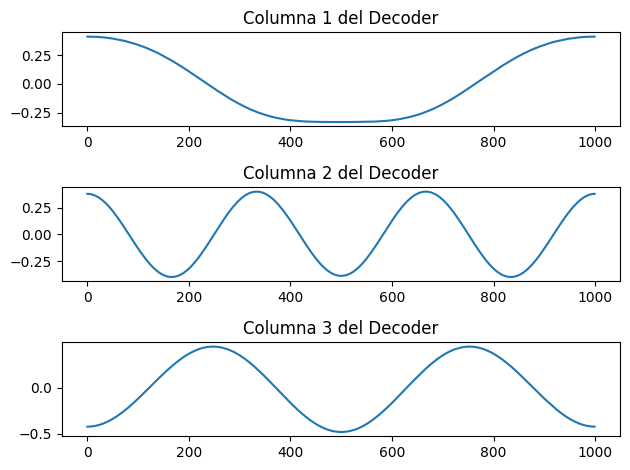

In [ ]:
p = param_modelo[2].shape[1]
fig, axs = plt.subplots(p,1)
for i in range(p):
  axs[i].plot(param_modelo[2][:,i].cpu().detach().numpy())
  axs[i].set_title(f"Columna {i+1} del Decoder")
fig.tight_layout()
plt.show()

#Interpretación
El Decoder debe aprender las tres componentes senoidales con frecuencia fija: \
$cos(2\pi t)$ \
$cos(4\pi t)$ \
$cos(6\pi t)$ \
cuyas combinaciones lineales dan lugar a las señales del dataset. \
Podemos visualizar estas tres señales a continuación.

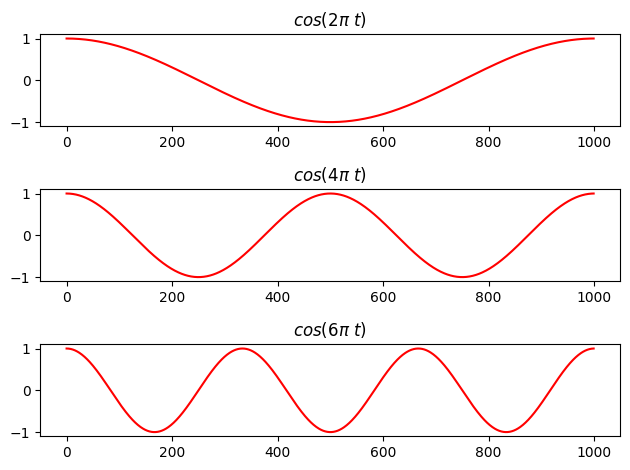

In [ ]:
t = np.linspace(0,1-1/N,N)
x1 = np.cos(2*np.pi*t)
x2 = np.cos(4*np.pi*t)
x3 = np.cos(6*np.pi*t)

xs = [x1, x2, x3]

fig, axs = plt.subplots(3,1)
for i in range(len(xs)):
  axs[i].plot(xs[i],"-r")
  axs[i].set_title(f"$cos({2*(i+1)}\pi \ t)$")
fig.tight_layout()
plt.show()



Además, las columnas de las matrices de la capa Fully Connected del encoder y decoder, deberían ser ortogonales, por lo que el producto punto entre estas columnas deberían tender a 0.
Veamos lo que dan:

In [ ]:
def column_dot_product(matrix):
    """
    Calcula el producto punto entre cada par de columnas de una matriz.

    Args:
        matrix (np.ndarray): Matriz de entrada (m x n).

    Returns:
        np.ndarray: Matriz de productos punto de tamaño (n x n),
                    donde el elemento (i, j) es el producto punto de
                    la columna i con la columna j.
    """
    # Obtener dimensiones de la matriz
    num_rows, num_cols = matrix.shape

    # Verificar si hay más filas que columnas
    if num_rows < num_cols:
        # Calcular el producto punto entre filas
        dot_products = {}
        for i in range(num_rows):
          for j in range(i+1,num_rows):
            dot_products[(i,j)] = np.dot(matrix[i, :], matrix[j, :])
    else:
        # Calcular el producto punto entre columnas
        dot_products = {}
        for i in range(num_cols):
          for j in range(i+1,num_cols):
            dot_products[(i,j)] = np.dot(matrix[:, i], matrix[:, j])

    return dot_products

matriz_encoder = param_modelo[0].cpu().detach().numpy()
matriz_decoder = param_modelo[2].cpu().detach().numpy()

dot_product_encoder = column_dot_product(matriz_encoder)
dot_product_decoder = column_dot_product(matriz_decoder)

print("------------------ Encoder -----------------")
print(matriz_encoder.shape)
for (i,j), value in dot_product_encoder.items():
  print(f"Producto punto entre fila {i+1} y {j+1}: {value:.4f}")

print("------------------ Decoder -----------------")
print(matriz_decoder.shape)
for (i,j), value in dot_product_decoder.items():
  print(f"Producto punto entre columna {i+1} y {j+1}: {value:.4f}")


------------------ Encoder -----------------
(3, 1000)
Producto punto entre fila 1 y 2: 0.0025
Producto punto entre fila 1 y 3: 0.0097
Producto punto entre fila 2 y 3: 0.0115
------------------ Decoder -----------------
(1000, 3)
Producto punto entre columna 1 y 2: -6.9387
Producto punto entre columna 1 y 3: -3.5102
Producto punto entre columna 2 y 3: 0.7021
